In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import time

In [8]:
import pathlib
import sys
p = pathlib.Path('.').absolute().parent
sys.path.append(str(p))
from tuner import util

show influence of 

  * interval length
  * sampling rate
  * window function
  * noise
  
on the discrete Fourier transform

freq 1: 27.5 (172.78759594743863)
freq 2: 55.0 (345.57519189487726)
freq 3: 82.5 (518.3627878423158)
number of cycles: 5  , samples per cycle: 12.3
        max time: 0.18181818181818182
   sampling rate: 338.25 [num per sec.]
         samples: 61
least sq omg_base: 27.5Hz, ref: 27.5Hz (6.47ms)
list compr. 17.1ms, numpy 2.21ms
list compr. 18.3ms, numpy 2.34ms
list compr. 18.2ms, numpy 2.32ms
------------------------

number of cycles: 5  , samples per cycle: 24.3
        max time: 0.18181818181818182
   sampling rate: 668.25 [num per sec.]
         samples: 121
least sq omg_base: 27.5Hz, ref: 27.5Hz (11.4ms)
list compr. 34ms, numpy 6.67ms
list compr. 31.7ms, numpy 4.64ms
list compr. 27ms, numpy 4.58ms
------------------------

number of cycles: 5  , samples per cycle: 36.3
        max time: 0.18181818181818182
   sampling rate: 998.25 [num per sec.]
         samples: 181
least sq omg_base: 27.5Hz, ref: 27.5Hz (7.66ms)
list compr. 24.4ms, numpy 7.09ms
list compr. 24.4ms, numpy 7.01ms
lis

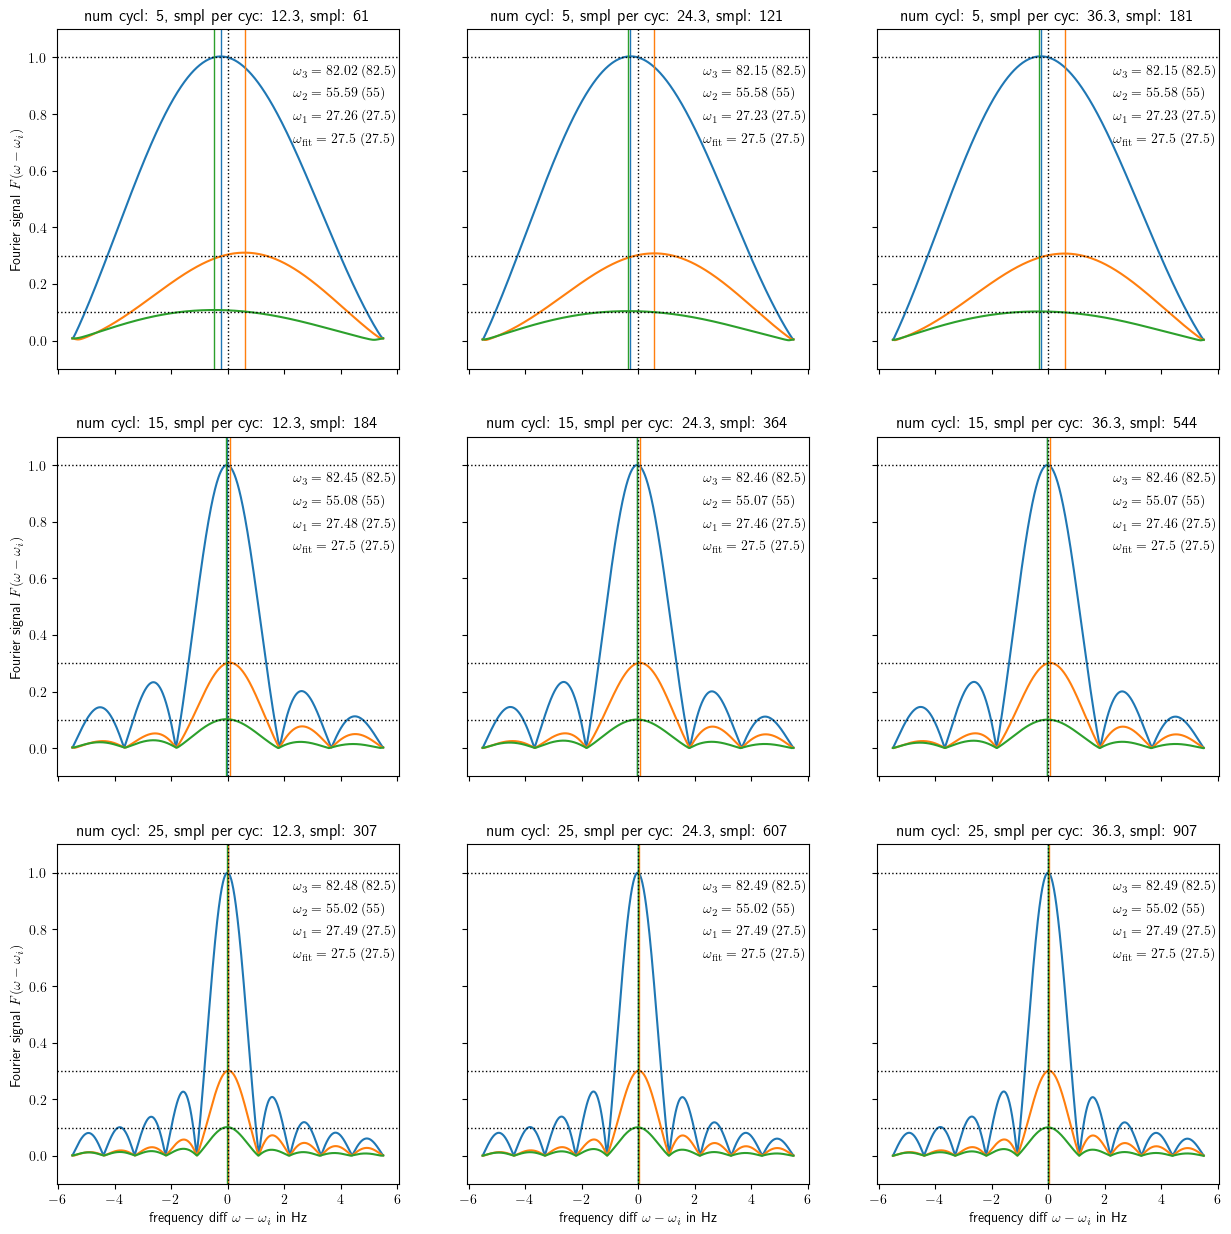

In [21]:
import importlib
importlib.reload(util)

f_base = 27.5 #Hz

w1 = f_base * 2 * np.pi
a1 = 1
phi1 = 0

w2 = 2*w1
a2 = 0.3
phi2 = 0.5

w3 = 3*w1
a3 = 0.1
phi3 = 2.1

noise_strength = 0

for i in range(1, 4):
    print("freq {}: {} ({})".format(i, i*f_base, i*f_base*2*np.pi))

num_cyc_list = [5, 15, 25]
samples_per_cycle_list = [12.3, 24.3, 36.3]

fig, ax = plt.subplots(
    ncols=len(num_cyc_list), 
    nrows=len(samples_per_cycle_list), 
    figsize=(15,15),
    sharex='all',
    sharey='all')

for i, num_cyc in enumerate(num_cyc_list):
    ax[i, 0].set_ylabel("Fourier signal $F(\omega-\omega_i)$")
    for j, samples_per_cycle in enumerate(samples_per_cycle_list):
        if i == 0:
            ax[-1, j].set_xlabel("frequency diff $\omega-\omega_i$ in Hz")
        print("number of cycles: {}  , samples per cycle: {}".format(num_cyc, samples_per_cycle))
        tmax = num_cyc / f_base                             # in sec.
        print("        max time: {}".format(tmax))
        sampling_rate = num_cyc * samples_per_cycle / tmax    # number per sec.
        print("   sampling rate: {} [num per sec.]".format(sampling_rate))
        N = int(tmax*sampling_rate)
        print("         samples: {}".format(N))
        t, dt = np.linspace(0, tmax, N, retstep=True)
        t_mid = tmax / 2
        t_sig = 0.3*t_mid
        #window = 2*np.exp(-(t-t_mid)**2 / 2 / t_sig**2) / np.sqrt(2*np.pi) / t_sig
        window = 1
        sig_t = a1*np.sin(w1*t + phi1) + a2*np.sin(w2*t + phi2) + a3 * np.sin(w3*t + phi3) + noise_strength*np.random.randn(N)
        
        t0 = time.perf_counter_ns()
        omg_base, amp, phi, optimality = util.fit_harmonic_function(
            signal_t=sig_t,
            t=t,
            omg_guess=1.02*w1,
            N=3
        )
        t1 = time.perf_counter_ns()
        print("least sq omg_base: {:.3g}Hz, ref: {:.3g}Hz ({:.3g}ms)".format(
            omg_base/(2*np.pi), f_base, (t1-t0)/10**6))
        
        
        
        axc = ax[i, j]
        d_w = 0.2*w1
        for k, wc in enumerate([w1, w2, w3]):
            w_list = np.linspace(wc - d_w, wc+d_w, 750)
            t0 = time.perf_counter_ns()
            ft_sig = np.asarray([dt*np.sum(window*sig_t * np.exp(1j*wi*t)) for wi in w_list])
            ft_sig /= tmax
            t1 = time.perf_counter_ns()
            ft_sig2 = np.sum(window*sig_t * np.exp(1j*w_list.reshape(-1, 1)*t), axis=1) * 2 * dt / tmax
            t2 = time.perf_counter_ns()
            
            print("list compr. {:.3g}ms, numpy {:.3g}ms".format( (t1-t0)/10**6, (t2-t1)/10**6))
            p, = axc.plot((w_list-wc)/2/np.pi, np.abs(ft_sig2))
            idx = np.argmax(np.abs(ft_sig2))
            axc.axvline((w_list[idx] - wc)/2/np.pi, color=p.get_color(), lw=1)
            axc.text(
                s=r"$\omega_{} = {:.4g} \; ({:.4g})$".format(k+1, w_list[idx]/2/np.pi, (k+1)*f_base), 
                x=2.3, 
                y=0.7 + (k+1)*0.08
            )
        axc.text(
            s=r"$\omega_\mathrm{{fit}} = {:.4g} \; ({:.4g})$".format(omg_base/2/np.pi, f_base), 
            x=2.3, 
            y=0.7
        )
            
        axc.axvline(0, color='k', ls=':', lw=1)
        axc.axhline(a1, color='k', ls=':', lw=1)
        axc.axhline(a2, color='k', ls=':', lw=1)
        axc.axhline(a3, color='k', ls=':', lw=1)
        axc.set_ylim([-0.1, 1.1])
        axc.set_title("num cycl: {}, smpl per cyc: {}, smpl: {}".format(num_cyc, samples_per_cycle, N))
        print("-"*24)
        print()